<a href="https://colab.research.google.com/github/niobeus/meters_reading/blob/main/FindDigits_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка файлов

In [ ]:
# load files
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
    name=fn, length=len(uploaded[fn])))

Saving 2.jpg to 2.jpg
Saving 1.jpg to 1.jpg
User uploaded file "2.jpg" with length 283571 bytes
User uploaded file "1.jpg" with length 35247 bytes


Обработка изображений

In [ ]:
import cv2
import imutils
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# filename = "1.jpg"
filename = "2.jpg"

image = cv2.imread(filename)

image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# выделение границ
blurred = cv2.GaussianBlur(gray, (7, 7), 1)
edged = cv2.Canny(blurred, 50, 200, 255)

In [ ]:
# нахождение контуров
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
display_cnt = None

for c in cnts:
	# аппроксимация контура
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

	# если это четырехугольник, то подходит
	if len(approx) == 4:
		display_cnt = approx
		break

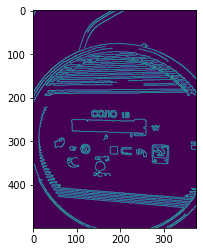

In [ ]:
plt.imshow(edged)

In [ ]:
print(display_cnt[0][0])

[258 254]


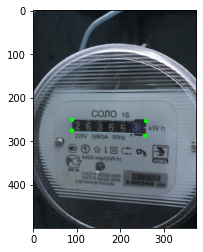

In [ ]:
im_cop = image.copy()
xx = display_cnt
cv2.drawContours(im_cop,display_cnt,-1,(0,255,0),9)
plt.imshow(im_cop)

In [ ]:
def orderPoints(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
 
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
 
	return rect

In [ ]:
def fourPointTransform(image, pts):
	rect = orderPoints(pts)
	(tl, tr, br, bl) = rect
	width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	max_width = max(int(width_a), int(width_b))
	height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	height_a = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	max_height = max(int(height_a), int(height_a))
	dst = np.array([
		[0, 0],
		[max_width - 1, 0],
		[max_width - 1, max_height - 1],
		[0, max_height - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (max_width, max_height))
	return warped

In [ ]:
# убираем искажения перспективы
warped = fourPointTransform(gray, display_cnt.reshape(4, 2))
output = fourPointTransform(image, display_cnt.reshape(4, 2))

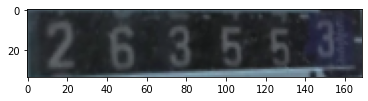

In [ ]:
plt.imshow(output)

In [ ]:
def reduseNonuniformIllumination(in_img):
  in_hsv = cv2.cvtColor(in_img, cv2.COLOR_BGR2HSV)
  hsv_planes = cv2.split(in_hsv)
  
  brightness = hsv_planes[2]
  brightness = cv2.bitwise_not(brightness)
  
  m = np.mean(brightness)
  brightness = brightness + m * 0.45
  brightness = cv2.bitwise_not(brightness)
  
  out_img = cv2.merge(hsv_planes);
  out_img = cv2.cvtColor(out_img, cv2.COLOR_HSV2BGR)
  return out_img

In [ ]:
def grayWorldFiltering(in_img):
  out_img = cv2.cvtColor(in_img, cv2.COLOR_BGR2LAB)
  avg_a = np.average(out_img[:, :, 1])
  avg_b = np.average(out_img[:, :, 2])
  out_img[:, :, 1] = out_img[:, :, 1] - ((avg_a - 128) * (out_img[:, :, 0] / 255.0) * 1.1)
  out_img[:, :, 2] = out_img[:, :, 2] - ((avg_b - 128) * (out_img[:, :, 0] / 255.0) * 1.1)
  out_img = cv2.cvtColor(out_img, cv2.COLOR_LAB2BGR)
  return out_img

In [ ]:
def gammaCorrection(in_img):
  brightness = np.average(in_img)
  gamma = -0.7 / np.log10(brightness / 255.0)
  lookup_table = np.array([np.ubyte(pow(i / 255.0, gamma) * 255.0) for i in range(0,256)])
  out_img = cv2.LUT(in_img, lookup_table
  return out_img

In [ ]:
# убираем недостатки освящения, баланса белого, выполняем гамма-коррекцию
# чтобы контур цифр стал более четкий
# чтобы бинаризация прошла с наименьшим искажением контура
illuminated = reduseNonuniformIllumination(output)
flitered = grayWorldFiltering(illuminated)
g_corrected = gammaCorrection(flitered)

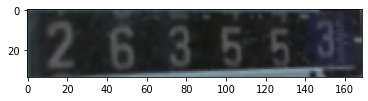

In [ ]:
plt.imshow(g_corrected)

In [ ]:
gray = cv2.cvtColor(g_corrected, cv2.COLOR_BGR2GRAY)

Выделение цифр

In [ ]:
thresh = cv2.adaptiveThreshold(gray,255.0,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 11, 0)
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

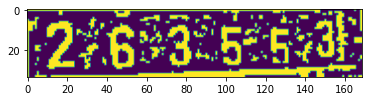

In [ ]:
plt.imshow(thresh)

In [ ]:
# находим контуры на бинаризированном изображении
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digit_cnts = []
rects = []

for c in cnts:
  # описываем контур прямоугольником
  (x, y, w, h) = cv2.boundingRect(c)
  # ищем прямоугольник подходящего размера
  if (w >= 9 and w < 40) and (h >= 17 and h <= 25):
    rects.append((x, y, w, h))
    digit_cnts.append(c)


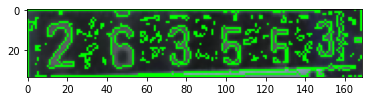

In [ ]:
out_copy = output.copy()
cv2.drawContours(out_copy,cnts,-1,(0,255,0),1)
plt.imshow(out_copy)

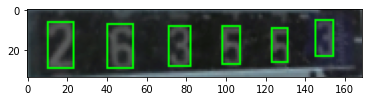

In [ ]:
out_copy = g_corrected.copy()
for rect in rects:
  cv2.rectangle(out_copy,rect ,(0,255,0), 1)
plt.imshow(out_copy)

In [ ]:
print(rects[0])

(123, 9, 9, 18)


In [ ]:
digits_im = []
rects.sort(key = lambda x: x[0])
for x, y, w, h in rects:
  # выделяем найденные прямоугольники
  digit = thresh[y:y+h, x:x+w]
  digits_im.append(digit)

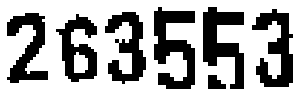

In [ ]:
index = 0
for dig in digits_im:
  plt.subplot(1, 7, index + 1)
  index += 1
  plt.axis('off')
  plt.imshow(dig, cmap=plt.cm.gray_r, interpolation='nearest')

In [ ]:
# выполняем небольшую морфологическую обработку, чтобы найденные цифры стали более похожи на рукописные
# также эрозия и открытие должны убрать некоторые погрешности бинаризации
igits_p = []
for dig in digits_im:
  dig = cv2.resize(dig, (28,28))
  # dig = cv2.adaptiveThreshold(dig, 255.0,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
  #         cv2.THRESH_BINARY,21,3)
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 4))
  dig = cv2.morphologyEx(dig, cv2.MORPH_ERODE, kernel)
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
  dig = cv2.morphologyEx(dig, cv2.MORPH_OPEN, kernel)
  dig = dig.astype('float32') / 255
  digits_p.append(dig)

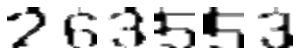

In [ ]:
index = 0
for dig in digits_p:
  plt.subplot(1, 7, index + 1)
  index += 1
  plt.axis('off')
  plt.imshow(dig, cmap=plt.cm.gray_r, interpolation='spline36')

Обучение нейронной сети

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

Using TensorFlow backend.


In [ ]:
from keras.datasets import mnist
from keras.utils import to_categorical

In [ ]:
(train_images,train_labels),(test_images,test_labels) = mnist.load_data()

train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_images,train_labels,epochs=5,batch_size=64)

11493376/11490434 [==============================] - 1s 0us/step
Epoch 1/5
60000/60000 [==============================] - 11s 175us/step - loss: 0.1760 - accuracy: 0.9449
Epoch 2/5
60000/60000 [==============================] - 4s 70us/step - loss: 0.0473 - accuracy: 0.9850
Epoch 3/5
60000/60000 [==============================] - 4s 70us/step - loss: 0.0330 - accuracy: 0.9899
Epoch 4/5
60000/60000 [==============================] - 4s 73us/step - loss: 0.0240 - accuracy: 0.9924
Epoch 5/5
60000/60000 [==============================] - 5s 75us/step - loss: 0.0194 - accuracy: 0.9942


Распознавание цифр

In [ ]:
predictions = []

for dig in digits_p:
  dig = np.expand_dims(dig, axis=0)
  dig = np.expand_dims(dig, axis=3)
  p = model.predict(dig)
  predictions.append(p)

In [ ]:
print(predictions[5])

[[3.5454589e-06 6.9462147e-04 1.7571803e-03 9.9676454e-01 1.2780381e-05
  2.5852905e-05 2.3719026e-07 6.8041816e-04 4.3788612e-05 1.7087907e-05]]


In [ ]:
# результат
for p in predictions:
  print(np.argmax(p))

2
6
3
5
5
3
